In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import torch
from torchvision import transforms, datasets


train_nm = 'train'
val_nm = 'val'

data_transforms = {
    train_nm: transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val_nm: transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content/drive/MyDrive/emotions_ds/emotions_ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [train_nm, val_nm]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True,) for x in [train_nm, val_nm]}

dataset_sizes = {x: len(image_datasets[x]) for x in [train_nm, val_nm]}
class_names = image_datasets[train_nm].classes

In [3]:
class_names

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [23]:
dataset_sizes

{'train': 37557, 'val': 4000}

In [31]:
image, label = next(iter(dataloaders[train_nm]))
image.numpy().shape

(256, 3, 128, 128)

In [32]:
label

tensor([2, 1, 0, 7, 2, 3, 5, 0, 5, 1, 3, 0, 2, 0, 7, 4, 1, 0, 3, 3, 4, 3, 1, 0,
        1, 0, 0, 7, 1, 0, 6, 6, 6, 5, 7, 0, 2, 2, 5, 3, 5, 0, 5, 0, 5, 1, 6, 5,
        0, 4, 3, 7, 2, 2, 0, 2, 4, 2, 2, 6, 4, 6, 0, 3, 5, 7, 3, 3, 6, 1, 0, 3,
        0, 6, 6, 3, 7, 1, 1, 2, 7, 6, 1, 0, 5, 5, 4, 1, 0, 0, 4, 3, 1, 7, 6, 3,
        1, 2, 4, 7, 7, 2, 7, 1, 5, 3, 2, 6, 2, 1, 3, 5, 1, 7, 7, 7, 4, 3, 3, 7,
        3, 1, 3, 3, 0, 4, 7, 2, 3, 5, 1, 7, 2, 4, 6, 3, 0, 5, 4, 0, 6, 5, 0, 1,
        4, 0, 3, 5, 2, 5, 5, 5, 7, 7, 4, 6, 1, 7, 6, 0, 2, 7, 5, 0, 5, 7, 5, 7,
        4, 6, 7, 5, 2, 7, 5, 0, 0, 5, 3, 7, 0, 2, 0, 5, 6, 3, 2, 3, 4, 1, 6, 2,
        1, 6, 7, 5, 7, 4, 7, 2, 6, 0, 4, 1, 1, 5, 7, 3, 0, 2, 2, 3, 0, 7, 6, 4,
        3, 0, 3, 0, 3, 6, 2, 5, 0, 2, 3, 2, 6, 3, 0, 4, 0, 3, 1, 6, 4, 0, 1, 1,
        7, 5, 0, 2, 0, 7, 4, 3, 2, 6, 0, 3, 1, 3, 6, 5])

In [33]:
image = image.view(-1, *image.size()[2:])

(-0.5, 127.5, 127.5, -0.5)

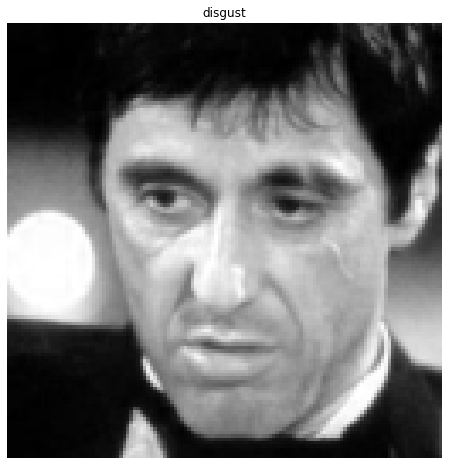

In [34]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
plt.imshow(image[0], cmap='binary_r')
plt.title(class_names[label[0]])
plt.axis('off')

In [9]:
import torchvision
import torchvision.models as models
from torch import nn

model = torchvision.models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features
n_classes = len(class_names)

model.fc = nn.Sequential(nn.Flatten(),
                         nn.Linear(n_inputs, 128),
                         nn.ReLU(),
                         nn.Linear(128, n_classes),
                         nn.Softmax(dim=1))

model.aux_logits = False

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    model.cuda()

def train_model(model, dataloaders, criterion, optimizer, epochs=15):
    for epoch in range(epochs):
        print(f'\n{epoch+1} / {epochs}')
        print('-'*20)
        
        for phase in [train_nm, val_nm]:
            if phase == train_nm:
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            correct = 0
            
            for X, y in dataloaders[phase]:
                X, y = X.cuda(), y.cuda()
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == train_nm):
                    out = model(X)
                    loss = criterion(out, y)
                    _, preds = torch.max(out, 1)
                    
                    if phase == train_nm:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * X.size(0)
                correct += torch.sum(preds == y.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase}: loss {epoch_loss:.4f}, acc {epoch_acc:.3f}')

           
train_model(model, dataloaders, criterion, optimizer, 5)

cuda:0

1 / 5
--------------------
train: loss 2.0443, acc 0.203
val: loss 2.0672, acc 0.173

2 / 5
--------------------
train: loss 2.0366, acc 0.209
val: loss 2.0646, acc 0.177

3 / 5
--------------------
train: loss 2.0262, acc 0.226
val: loss 2.0604, acc 0.186

4 / 5
--------------------
train: loss 2.0223, acc 0.232
val: loss 2.0603, acc 0.186

5 / 5
--------------------
train: loss 2.0192, acc 0.236
val: loss 2.0599, acc 0.186


In [17]:
true_labels = torch.tensor([]).to(device)
labels = torch.tensor([]).to(device)

for batch, (X, y) in enumerate(dataloaders[val_nm]):
    X, y = X.to(device), y.to(device)
    true_labels = torch.cat((true_labels, y), 0)
    preds = model(X)
    _, preds = torch.max(preds, dim=1)
    labels = torch.cat((labels, preds), 0)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification report \n')
print(classification_report(true_labels.cpu(), labels.cpu(), target_names=class_names))
conf_matrix = confusion_matrix(true_labels.cpu(), labels.cpu(), normalize='true')
print('Confusion matrix \n')
print(conf_matrix.round(2))

Classification report 

              precision    recall  f1-score   support

       anger       0.16      0.40      0.23       500
    contempt       0.22      0.11      0.15       500
     disgust       0.00      0.00      0.00       500
        fear       0.20      0.36      0.26       500
       happy       0.21      0.17      0.19       500
     neutral       0.18      0.24      0.21       500
         sad       0.00      0.00      0.00       500
    surprise       0.18      0.20      0.19       500

    accuracy                           0.19      4000
   macro avg       0.14      0.19      0.15      4000
weighted avg       0.14      0.19      0.15      4000

Confusion matrix 

[[0.4  0.07 0.   0.18 0.07 0.14 0.   0.13]
 [0.32 0.11 0.   0.16 0.12 0.18 0.   0.1 ]
 [0.34 0.05 0.   0.2  0.12 0.15 0.   0.15]
 [0.23 0.02 0.   0.36 0.07 0.14 0.   0.18]
 [0.26 0.07 0.   0.18 0.17 0.19 0.   0.12]
 [0.29 0.06 0.   0.18 0.09 0.24 0.   0.13]
 [0.35 0.06 0.   0.24 0.1  0.15 0.   0.11]
 [0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


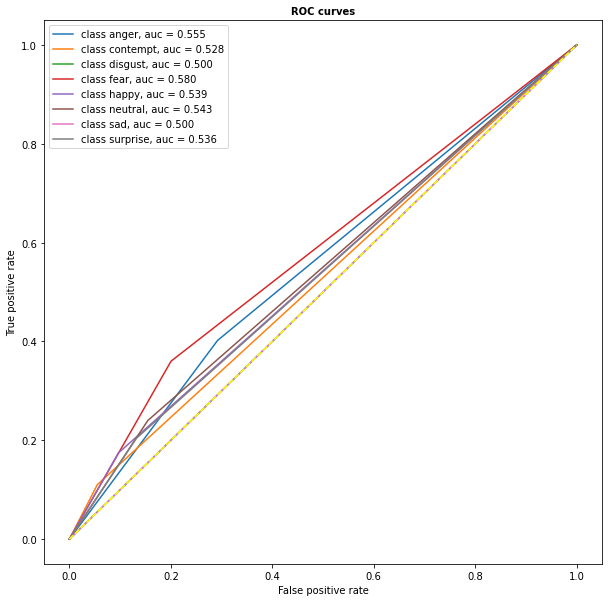

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig = plt.figure(figsize=(10, 10))

n_classes = len(class_names)
lab_plt = [(true_labels.cpu() == float(i)) for i in range(n_classes)]
outs_plt = [(labels.cpu() == float(i)) for i in range(n_classes)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curves', fontweight='bold', fontsize=10)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f'class {class_names[i]}, auc = {roc_auc[i]:.3f}' )

plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--', color='yellow')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

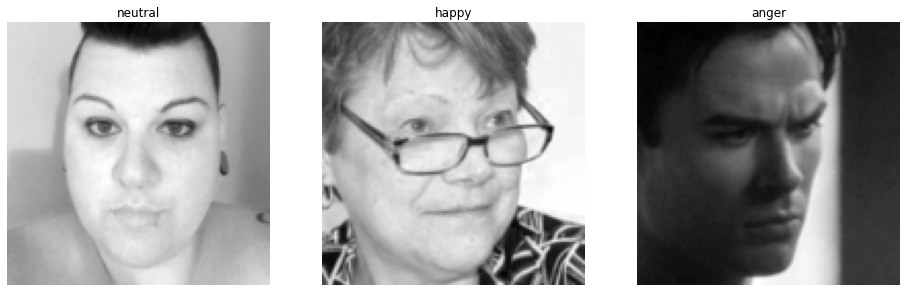

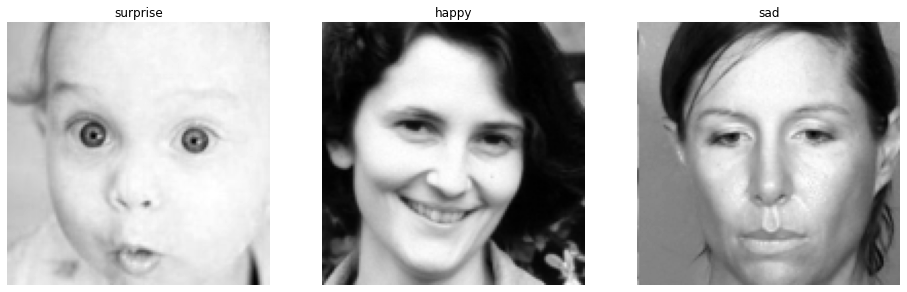

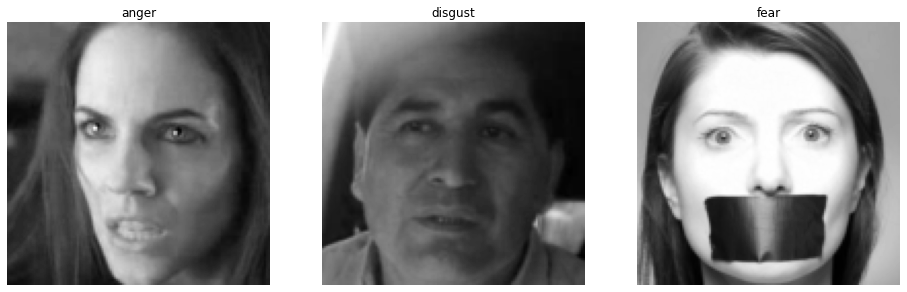

In [35]:
count = 0
for img, label in dataloaders[val_nm]:
    plt.figure(figsize=(16, 16))
    count += 1
    img = img.to(device)
    pred = model(img)
    pred = torch.max(pred, dim=1)
    img = img.view(-1, *img.size()[2:])
    for i in range(3):
        ax = plt.subplot(1, 3, 1+i)
        plt.imshow(img[i*3].cpu(), cmap='binary_r')
        plt.title(class_names[label[0+i]])
        plt.axis('off')
    if count == 3:
        break

# Opinion on the accuracy of the NN
#### Firstly, a lot of photos are distributed incorrectly
#### Secondly, there are photos in which emotions are not strongly expressed
#### Finally, there are overlapped faces (picture 9 above), turned faces and other defectsin the pictures